In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
import joblib

In [2]:
# 导入数据，设置列名
def readDatasets(train_path, validation_path, test_path):
    wdbc_train = pd.read_csv(train_path, header=None, sep=',')
    wdbc_val = pd.read_csv(validation_path, header=None, sep=',')
    wdbc_test = pd.read_csv(test_path, header=None, sep=',')
    wdbc_train.columns = ['id','diagnosis','radius_mean','texture_mean','perimeter_mean','area_mean','smoothness_mean','compactness_mean','concavity_mean','concave points_mean','symmetry_mean','fractal_dimension_mean','radius_se','texture_se','perimeter_se','area_se','smoothness_se','compactness_se','concavity_se','concave points_se','symmetry_se','fractal_dimension_se','radius_worst','texture_worst','perimeter_worst','area_worst','smoothness_worst','compactness_worst','concavity_worst'	'concave','points_worst','symmetry_worst','fractal_dimension_worst']
    wdbc_val.columns = ['id','diagnosis','radius_mean','texture_mean','perimeter_mean','area_mean','smoothness_mean','compactness_mean','concavity_mean','concave points_mean','symmetry_mean','fractal_dimension_mean','radius_se','texture_se','perimeter_se','area_se','smoothness_se','compactness_se','concavity_se','concave points_se','symmetry_se','fractal_dimension_se','radius_worst','texture_worst','perimeter_worst','area_worst','smoothness_worst','compactness_worst','concavity_worst'	'concave','points_worst','symmetry_worst','fractal_dimension_worst']
    wdbc_test.columns = ['id','diagnosis','radius_mean','texture_mean','perimeter_mean','area_mean','smoothness_mean','compactness_mean','concavity_mean','concave points_mean','symmetry_mean','fractal_dimension_mean','radius_se','texture_se','perimeter_se','area_se','smoothness_se','compactness_se','concavity_se','concave points_se','symmetry_se','fractal_dimension_se','radius_worst','texture_worst','perimeter_worst','area_worst','smoothness_worst','compactness_worst','concavity_worst'	'concave','points_worst','symmetry_worst','fractal_dimension_worst']
    return wdbc_train, wdbc_val, wdbc_test

In [3]:
wdbc_train, wdbc_val, wdbc_test = readDatasets('wdbc_train.data', 'wdbc_validation.data', 'wdbc_test.data')
# 删除第0列（id无法提供有效信息）
wdbc_train, wdbc_val, wdbc_test = wdbc_train.drop('id', axis=1), wdbc_val.drop('id', axis=1), wdbc_test.drop('id', axis=1)

# 数据扩增，试图缓解分布不平衡问题
# y_train, y_val, y_test = wdbc_train.iloc[:,0], wdbc_val.iloc[:,0], wdbc_test.iloc[:,0]
# wdbc_train, wdbc_val, wdbc_test = wdbc_train.drop('diagnosis', axis=1), wdbc_val.drop('diagnosis', axis=1), wdbc_test.drop('diagnosis', axis=1)
# 显示原本的分布情况
# print('Original dataset shape {}, {}, {}'.format(Counter(y_train), Counter(y_val), Counter(y_test)))
# sm_balencer = SMOTE()
# # rebalence
# wdbc_train_res, y_train_res = sm_balencer.fit_resample(wdbc_train, y_train)
# wdbc_val_res, y_val_res = sm_balencer.fit_resample(wdbc_val, y_val)
# wdbc_test_res, y_test_res = sm_balencer.fit_resample(wdbc_test, y_test)
# # 显示平衡后的分布情况
# print('Original dataset shape {}, {}, {}'.format(Counter(y_train_res), Counter(y_val_res), Counter(y_test_res)))
# # 再将rebalence后的数据集拼回原来的样子
# wdbc_train_res['diagnosis'], wdbc_val_res['diagnosis'], wdbc_test_res['diagnosis'] = y_train_res, y_val_res, y_test_res

# 构造完整数据集
wdbc_full = pd.concat([wdbc_train, wdbc_val, wdbc_test])
wdbc_full = wdbc_full.reset_index(drop=True)
# 'diagnosis'编码为0/1
labelencoder = LabelEncoder()
wdbc_full['diagnosis'] = labelencoder.fit_transform(wdbc_full['diagnosis'])
wdbc_train['diagnosis'] = labelencoder.fit_transform(wdbc_train['diagnosis'])
wdbc_val['diagnosis'] = labelencoder.fit_transform(wdbc_val['diagnosis'])
wdbc_test['diagnosis'] = labelencoder.fit_transform(wdbc_test['diagnosis'])
wdbc_train, wdbc_val, wdbc_test = wdbc_train, wdbc_val, wdbc_test

In [4]:
wdbc_full['diagnosis'].value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

#### 数据预处理+特征工程

#### 1. 相关热力图——删除低线性相关的特征

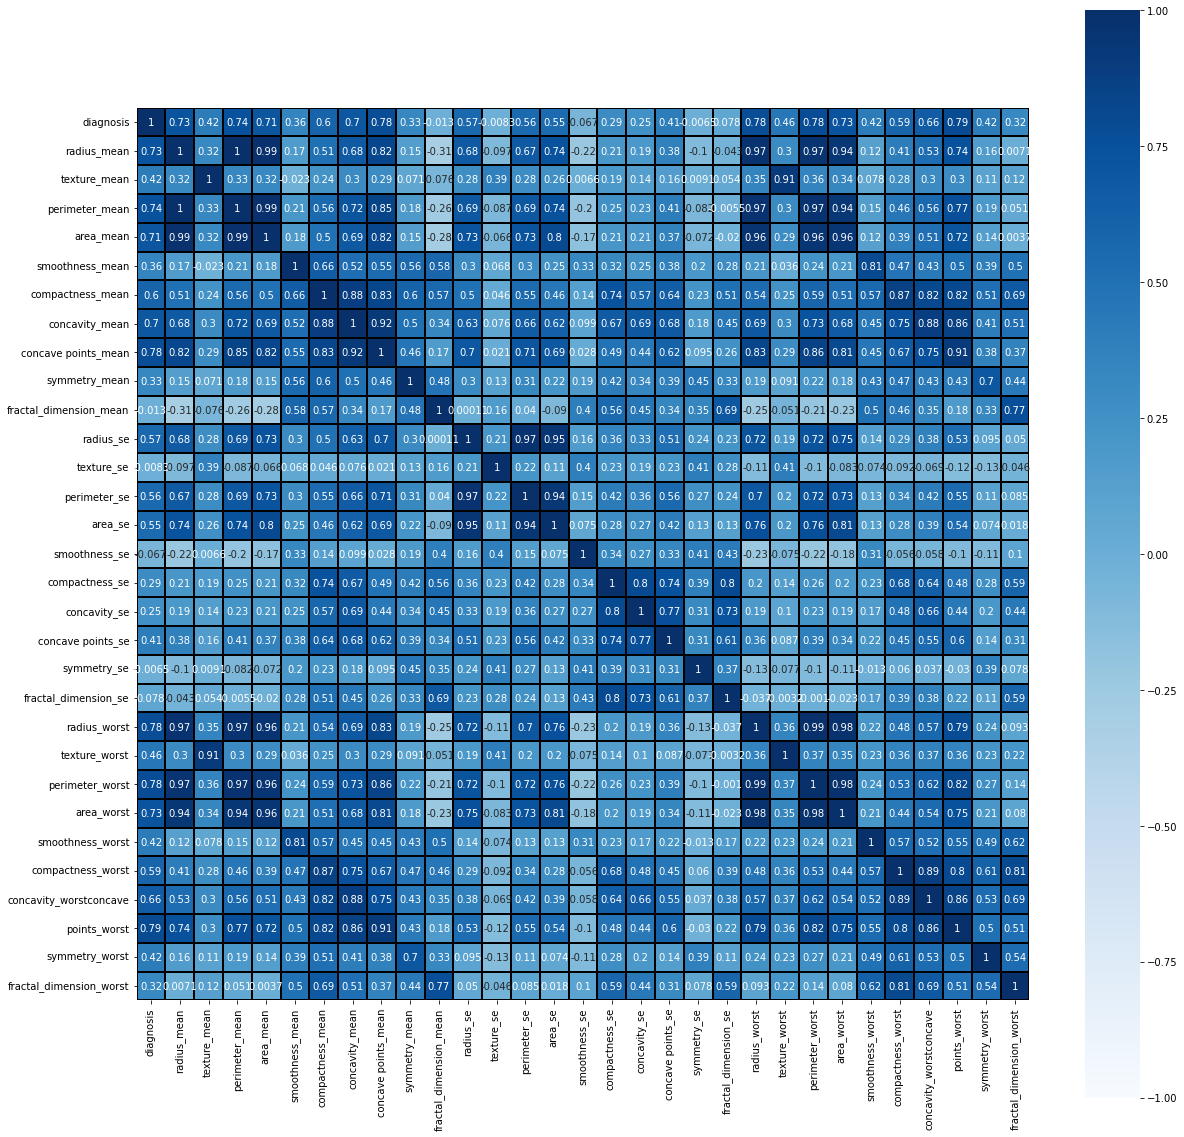

In [5]:
# 相关性
fig=plt.gcf()
fig.set_size_inches(20, 20)
fig=sns.heatmap(wdbc_full.corr(), annot=True, cmap='Blues', linewidths=1, linecolor='k', square=True, mask=False, vmin=-1, vmax=1, cbar_kws={"orientation": "vertical"}, cbar=True)

In [24]:
# 删除和diagnosis相关性较低的属性（<0.1）
# wdbc_train = wdbc_train.drop(['fractal_dimension_mean','texture_se','smoothness_se','symmetry_se','fractal_dimension_se'], axis=1)
# wdbc_val = wdbc_val.drop(['fractal_dimension_mean','texture_se','smoothness_se','symmetry_se','fractal_dimension_se'], axis=1)
# wdbc_test = wdbc_test.drop(['fractal_dimension_mean','texture_se','smoothness_se','symmetry_se','fractal_dimension_se'], axis=1)

#### 2. 互信息——进一步删除特征

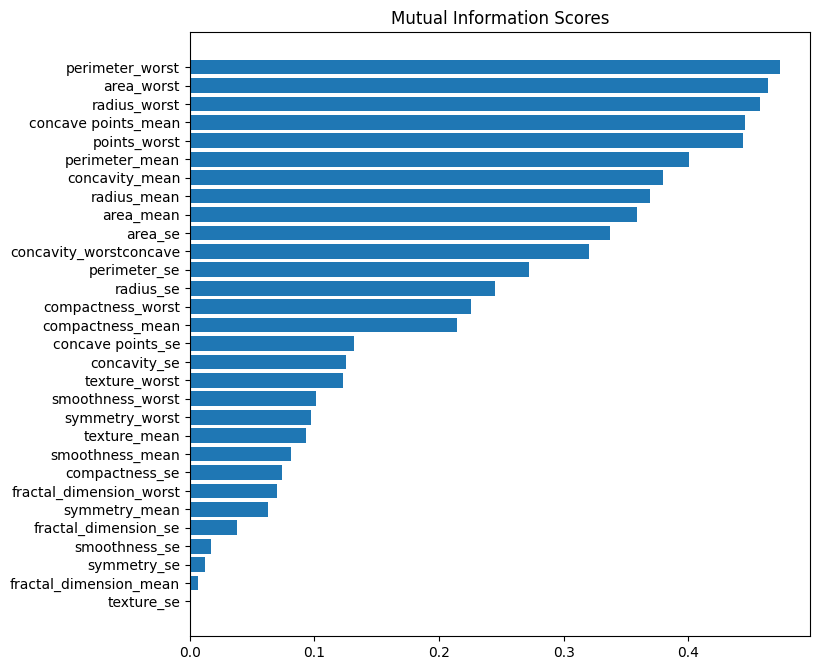

In [6]:
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt

# 计算所有特征与price之间的互信息，降序排列。互信息能捕捉任何相关性，不适用于稀疏矩阵
def make_mi_scores(X, y, features):
    mi_scores = mutual_info_regression(X, y, discrete_features=features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# 互信息值降序排列可视化
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

# 计算训练集特征和diagnosis间的互信息
mi_scores = make_mi_scores(wdbc_full.iloc[:,1:], wdbc_full.iloc[:,0], 'auto')
plt.figure(dpi=100, figsize=(8, 8))
plot_mi_scores(mi_scores)

In [26]:
# 进一步删除特征
# wdbc_train, wdbc_val, wdbc_test = wdbc_train.drop(['fractal_dimension_worst'], axis=1), wdbc_val.drop(['fractal_dimension_worst'], axis=1), wdbc_test.drop(['fractal_dimension_worst'], axis=1)

#### 3. 箱型图——寻找并剔除离群点

<AxesSubplot:xlabel='radius_mean'>

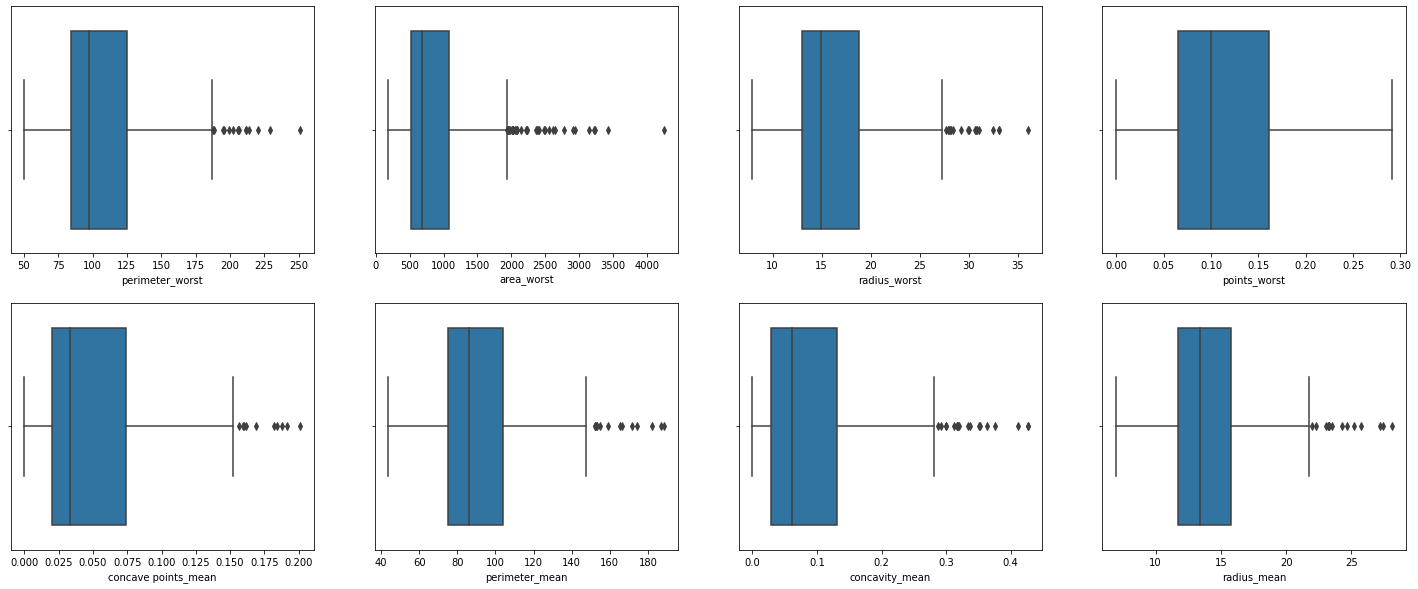

In [7]:
# 绘制若干重要特征的箱型图图，便于寻找离群点
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax_arr = plt.subplots(2,4, figsize=(25,10))
sns.boxplot(x=wdbc_full['perimeter_worst'], ax=ax_arr[0][0])
sns.boxplot(x=wdbc_full['area_worst'], ax=ax_arr[0][1])
sns.boxplot(x=wdbc_full['radius_worst'], ax=ax_arr[0][2])
sns.boxplot(x=wdbc_full['points_worst'], ax=ax_arr[0][3])
sns.boxplot(x=wdbc_full['concave points_mean'], ax=ax_arr[1][0])
sns.boxplot(x=wdbc_full['perimeter_mean'], ax=ax_arr[1][1])
sns.boxplot(x=wdbc_full['concavity_mean'], ax=ax_arr[1][2])
sns.boxplot(x=wdbc_full['radius_mean'], ax=ax_arr[1][3])

In [8]:
# 剔除离群点
wdbc_train, wdbc_val, wdbc_test = wdbc_train[wdbc_train['perimeter_worst'] < 225], wdbc_val[wdbc_val['perimeter_worst'] < 225], wdbc_test[wdbc_test['perimeter_worst'] < 225]
wdbc_train, wdbc_val, wdbc_test = wdbc_train[wdbc_train['area_worst'] < 3500], wdbc_val[wdbc_val['area_worst'] < 3500], wdbc_test[wdbc_test['area_worst'] < 3500]
wdbc_train, wdbc_val, wdbc_test = wdbc_train[wdbc_train['radius_worst'] < 30], wdbc_val[wdbc_val['radius_worst'] < 30], wdbc_test[wdbc_test['radius_worst'] < 30]
wdbc_train, wdbc_val, wdbc_test = wdbc_train[wdbc_train['concave points_mean'] < 0.175], wdbc_val[wdbc_val['concave points_mean'] < 0.175], wdbc_test[wdbc_test['concave points_mean'] < 0.175]
wdbc_train, wdbc_val, wdbc_test = wdbc_train[wdbc_train['perimeter_mean'] < 160], wdbc_val[wdbc_val['perimeter_mean'] < 160], wdbc_test[wdbc_test['perimeter_mean'] < 160]
wdbc_train, wdbc_val, wdbc_test = wdbc_train[wdbc_train['concavity_mean'] < 0.35], wdbc_val[wdbc_val['concavity_mean'] < 0.35], wdbc_test[wdbc_test['concavity_mean'] < 0.35]
wdbc_train, wdbc_val, wdbc_test = wdbc_train[wdbc_train['radius_mean'] < 25], wdbc_val[wdbc_val['radius_mean'] < 25], wdbc_test[wdbc_test['radius_mean'] < 25]

In [9]:
# 构造全体数据
X_full = wdbc_full.iloc[:, 1:]
y_full = wdbc_full.iloc[:, 0]
# 构造X（30个属性的矩阵）和y（标签向量）
X_train, y_train = wdbc_train.iloc[:, 1:], wdbc_train.iloc[:, 0]
X_val, y_val = wdbc_val.iloc[:, 1:], wdbc_val.iloc[:, 0]
X_test, y_test = wdbc_test.iloc[:, 1:], wdbc_test.iloc[:, 0]

In [10]:
# 标准化
X_train_scaled = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
X_val_scaled = (X_val - X_val.mean(axis=0)) / X_val.std(axis=0)
X_test_scaled = (X_test - X_test.mean(axis=0)) / X_test.std(axis=0)

#### 下面使用未标准化的、剔除离群点的原始数据进行聚类分析

In [11]:
# Kmeans
model_kmeans = KMeans(n_clusters=2)
model_kmeans.fit(X_train)
pred_kmeans = model_kmeans.predict(X_test)
NMI_kmeans = metrics.normalized_mutual_info_score(pred_kmeans, y_test)
NMI_kmeans

0.49334398854735917

In [12]:
# GaussianMixture
model_gm = GaussianMixture(n_components=2, covariance_type="full", tol=0.001, max_iter=100)
model_gm.fit(X_train)
pred_gm = model_gm.predict(X_test)
NMI_gm = metrics.normalized_mutual_info_score(pred_gm, y_test)
NMI_gm

0.4708157741993321

### 下方单元格是最优模型BayesianGaussianMixture，NMI=0.8078

In [13]:
# BayesianGaussianMixture
# model_bgm = BayesianGaussianMixture(n_components=2, covariance_type="full", tol=0.01, reg_covar=0.01, init_params='kmeans')
# model_bgm.fit(X_train)
# joblib.dump(model_bgm, "model_bgm.pth")
model_bgm = joblib.load("model_bgm.pth")
pred_bgm = model_bgm.predict(X_test)
NMI_bgm = metrics.normalized_mutual_info_score(pred_bgm, y_test)
NMI_bgm

0.8077926501995131

In [ ]:
# 可视化聚类结果
# X_test['pred_bgm'] = pred_bgm
# X_test['y_test'] = y_test
# fig, ax_arr = plt.subplots(1, 2, figsize=(10,6))
# sns.scatterplot(x='radius_mean', y='texture_mean', hue='pred_bgm', data=X_test, ax=ax_arr[0])
# sns.scatterplot(x='radius_mean', y='texture_mean', hue='y_test', data=X_test, ax=ax_arr[1])

In [14]:
# 层次聚类
model_ac = AgglomerativeClustering(n_clusters=2, linkage="ward")
pred_ac = model_ac.fit_predict(X_test)
NMI_ac = metrics.normalized_mutual_info_score(pred_ac, y_test)
NMI_ac

0.36434283430848696

#### 下面使用标准化后的数据进行聚类分析（仅用于进行对照实验）

In [15]:
# Kmeans
model_kmeans = KMeans(n_clusters=2)
model_kmeans.fit(X_train_scaled)
pred_kmeans = model_kmeans.predict(X_test_scaled)
NMI_kmeans = metrics.normalized_mutual_info_score(pred_kmeans, y_test)
NMI_kmeans

0.6574590118913402

In [16]:
# GaussianMixture
model_gm = GaussianMixture(n_components=2, covariance_type="full", tol=0.001, reg_covar=0.000001)
model_gm.fit(X_train_scaled)
pred_gm = model_gm.predict(X_test_scaled)
NMI_gm = metrics.normalized_mutual_info_score(pred_gm, y_test)
NMI_gm

0.6017819849224885

In [17]:
# BayesianGaussianMixture
model_bgm = BayesianGaussianMixture(n_components=2, covariance_type="full", tol=0.001, reg_covar=0.0001, init_params='kmeans')
model_bgm.fit(X_train_scaled)
pred_bgm = model_bgm.predict(X_test_scaled)
NMI_bgm = metrics.normalized_mutual_info_score(pred_bgm, y_test)
NMI_bgm

0.5300080047555541

In [18]:
# 层次聚类
model_ac = AgglomerativeClustering(n_clusters=2)
pred_ac = model_ac.fit_predict(X_test_scaled)
NMI_ac = metrics.normalized_mutual_info_score(pred_ac, y_test)
NMI_ac

0.4007791965322615